# GLUONTS

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import session_info

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

C:\Users\Italo\AppData\Roaming\Python\Python37\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [2]:
# Leitura dos Dados

df_bf = pd.read_excel('Botafogo-2015-2023_Semanal_Dengue.xlsx')
df_cd = pd.read_excel('CidadeDeDeus-2015-2023_Semanal_Dengue.xlsx')
df_cp = pd.read_excel('Copacabana-2015-2023_Semanal_Dengue.xlsx')
df_ed = pd.read_excel('EngenhoDeDentro-2015-2023_Semanal_Dengue.xlsx')
df_ip = pd.read_excel('Ipanema-2015-2023_Semanal_Dengue.xlsx')
df_lj = pd.read_excel('Laranjeiras-2015-2023_Semanal_Dengue.xlsx')
df_mc = pd.read_excel('Maracana-2015-2023_Semanal_Dengue.xlsx')
df_rc = pd.read_excel('Rocinha-2015-2023_Semanal_Dengue.xlsx')
df_vm = pd.read_excel('VilaMilitar-2015-2023_Semanal_Dengue.xlsx')
df_rl = pd.read_excel('Realengo\Realengo-2015-2023_Semanal_Dengue.xlsx')

In [3]:
dataframes = [df_bf, df_cd, df_cp, df_ed, df_ip, df_lj, df_mc, df_rc, df_vm, df_rl]
data = pd.concat(dataframes, ignore_index=False)

In [4]:
data.set_index('data', inplace=True)

In [5]:
# OneHotEncoding para a coluna 'bairro'
data = pd.get_dummies(data, columns=['bairro'])

In [6]:
# Substituir infinitos por NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Checar e preencher valores NaN
if data.isnull().any().any():
    data.fillna(method='ffill', inplace=True)  # Preencher com o último valor válido

In [7]:
exg = ['chuva', 'temperaturaMedia', 'temperaturaMaxima','temperaturaMinima', 'direcaoVento', 'velocidadeVento', 'pressaoAtmosferica', 'semana',
       'bairro_Botafogo', 'bairro_Cidade de Deus', 'bairro_Copacabana', 'bairro_Engenho de Dentro', 'bairro_Ipanema', 'bairro_Laranjeiras',
       'bairro_Maracana', 'bairro_Realengo', 'bairro_Rocinha', 'bairro_Vila Militar']

In [8]:
# Escalonamento dos dados (normalização)
scaler = StandardScaler()

data[exg] = scaler.fit_transform(data[exg].values)

In [9]:
prediction_length = 105

## DENGUE E CHIKUNGUNYA

In [10]:
# Preparar o conjunto de dados para treinamento
training_data = ListDataset(
    [{'start': data.index[0], 'target': data['dengueChikungunya'].to_numpy(), 'feat_dynamic_real': data[exg].T.to_numpy()}],
    freq='W'
)

# Ajustar o índice de início para o conjunto de teste corretamente
test_start_index = data.index[-prediction_length]

# Preparar os dados de teste
test_data = ListDataset(
    [{'start': test_start_index, 'target': data['dengueChikungunya'][-prediction_length:].to_numpy(), 'feat_dynamic_real': data[exg][-prediction_length:].T.to_numpy()}],
    freq='W'
)

In [11]:
# Configuração do Estimator
estimator = DeepAREstimator(
    freq='W',
    prediction_length=12,
    trainer=Trainer(epochs=50),
    use_feat_dynamic_real=True,
    cell_type ='lstm'
)

# Treinamento do modelo
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:10<00:00,  4.72it/s, epoch=50/50, avg_epoch_loss=-0.159]


In [12]:
# Previsão
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # Conjunto de dados de teste
    predictor=predictor,  # Modelo treinado
    num_samples=100  # Número de amostras para a geração de previsões
)

forecasts = list(forecast_it)
tss = list(ts_it)  # valores verdadeiros do conjunto de teste

<Figure size 1000x500 with 0 Axes>

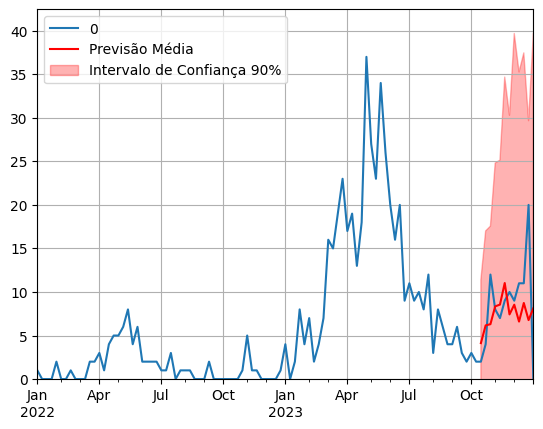

In [13]:
def plot_forecasts(ts_entry, forecast_entry):
    plt.figure(figsize=(10, 5))
    # Plot dos valores observados
    ts_entry.plot(label='Observado')
    
    # Obtenção das previsões e intervalos de confiança
    prediction_mean = forecast_entry.mean_ts

    # Plot da previsão média
    prediction_mean.plot(label='Previsão Média', color='r')
    
    # Plot do intervalo de confiança
    plt.fill_between(
        prediction_mean.index,
        forecast_entry.quantile(0.05),
        forecast_entry.quantile(0.95), 
        color='r',
        alpha=0.3,
        label='Intervalo de Confiança 90%' 
    )
    plt.legend(loc='upper left')
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.show()

# chamada para plotar o gráfico, usando o primeiro elemento do conjunto de testes e previsões
plot_forecasts(tss[0], forecasts[0])

In [14]:
# Avaliação do modelo usando a mediana das previsões
evaluator = Evaluator(quantiles=[0.5]) 

agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts))

# Métricas agregadas
print("Métricas agregadas:", agg_metrics)

# Métrica específica: MSE
mse = agg_metrics["MSE"]
print("Mean Squared Error (MSE):", mse)

Running evaluation: 1it [00:00, 55.55it/s]

Métricas agregadas: {'MSE': 26.722496032714844, 'abs_error': 51.484405517578125, 'abs_target_sum': 103.0, 'abs_target_mean': 8.583333333333334, 'seasonal_error': 2.5543478260869565, 'MASE': 1.6796330878075132, 'MAPE': 0.4428666288202459, 'sMAPE': 0.6345857779184977, 'MSIS': 20.994887418273493, 'QuantileLoss[0.5]': 51.484405517578125, 'Coverage[0.5]': 0.25, 'RMSE': 5.169380623702886, 'NRMSE': 0.6022579367420837, 'ND': 0.49984859725804004, 'wQuantileLoss[0.5]': 0.49984859725804004, 'mean_absolute_QuantileLoss': 51.484405517578125, 'mean_wQuantileLoss': 0.49984859725804004, 'MAE_Coverage': 0.25, 'OWA': nan}
Mean Squared Error (MSE): 26.722496032714844


# info

In [15]:
session_info.show(html=False)

-----
gluonts             0.13.9
matplotlib          3.5.3
numpy               1.21.6
pandas              1.2.5
session_info        1.0.0
sklearn             1.0.2
-----
IPython             7.34.0
jupyter_client      7.4.9
jupyter_core        4.12.0
-----
Python 3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19041-SP0
-----
Session information updated at 2024-08-20 18:03
